## Load and Evaluate the Experiments

This notebook is an interactive testing environment for now and will be used to generate the final plots for the accompanying paper. [Paper Citation]

## 1. Import Libraries

In [1]:
# ----------------
# import libraries
# ----------------

# standard libraries
# -----
import os
import sys
import random
import datetime


import numpy as np
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
# configuration module
# -----

sys.path.append(os.path.dirname(sys.path[0]))
#import config
from config import args

# define manual random seed
torch.manual_seed(args.seed)
random.seed(args.seed)
np.random.seed(args.seed)

# custom libraries
# -----
from utils.general import save_model, load_model, save_args, AverageMeter, DotDict
from utils.configurator import get_augmentations, get_dataloaders, get_network, get_optimizer, get_scheduler, update_lr, get_loss
from utils.evaluation import fuse_representations, lls_fit, lls_eval, supervised_eval, knn_eval, wcss_bcss, get_pacmap, train_linear_classifier, train_linear_regressor, evaluate, log_to_tensorboard
from utils.visualization import ConfusionMatrix
from utils.networks import LinearClassifier, DoubleOutput

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# macOS does do its own multiprocessing and does not like it prescribed
args.num_workers = 0 if torch.backends.mps.is_available() else args.num_workers


data_properties_dict = {
    'C3': DotDict({'rgb_mean': (0.3621, 0.3644, 0.3635),
           'rgb_std': (0.1456, 0.1479, 0.1477),
           'classes': [str(c) for c in range(0,50)],
           'n_classes': 50,
           }),
}

In [3]:
args.exp_dir = "/Users/markus/Research/Code/ColorConstancyLearning/learning/save/12-12-23_16-20__seed_0_C3_aug_time_SimCLR_reg_None"
# get the model you want to load
model_path = args.exp_dir + '/models/' + 'backbone_epoch_100.pt'
model = get_network(args, data_properties_dict).to(device)
load_model(model, model_path, device)
#model.load_state_dict(torch.load(model_path, map_location=torch.device('mps')))
model.eval()

# the DoubleOutput class is just needed because the fuse_representations function
# expects an output of (representation, projection) to work within the training loop
# and an encoder method that is only part of the network - I am faking this here with
# sequential modules to extract more representations

class layer3(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        model.layer2,
                        model.layer3,
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l3 = layer3()
l3.eval()

class layer2(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        model.layer2,
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l2 = layer2()
l2.eval()

class layer1(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = torch.nn.Sequential(
                        model.layer1,
                        torch.nn.Flatten(),
        )
        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l1 = layer1()
l1.eval()


class layer0(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        #self.encoder = torch.nn.Sequential(
        #                torch.nn.Flatten(),
        #)
        self.encoder = torch.nn.Flatten()

        self.out =  torch.nn.Sequential(
            self.encoder,
            DoubleOutput(),
        )

    def forward(self, x):
        return self.out(x)

l0 = layer0()
l0.eval()

#classifier.eval()

layer0(
  (encoder): Flatten(start_dim=1, end_dim=-1)
  (out): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): DoubleOutput()
  )
)

In [4]:
args.data_root = "/Users/markus/Research/Code/ColorConstancyLearning/learning/data"
# get the dataloaders for the dataset
dataloader_train, dataloader_train_eval, dataloader_test, dataset_train, dataset_train_eval, dataset_test = get_dataloaders(
    args, data_properties_dict)

[INFO:] Training set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/train'
[INFO:] Evaluation Training set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/train'
[INFO:] Test set at '/Users/markus/Research/Code/ColorConstancyLearning/learning/data/C3/test'


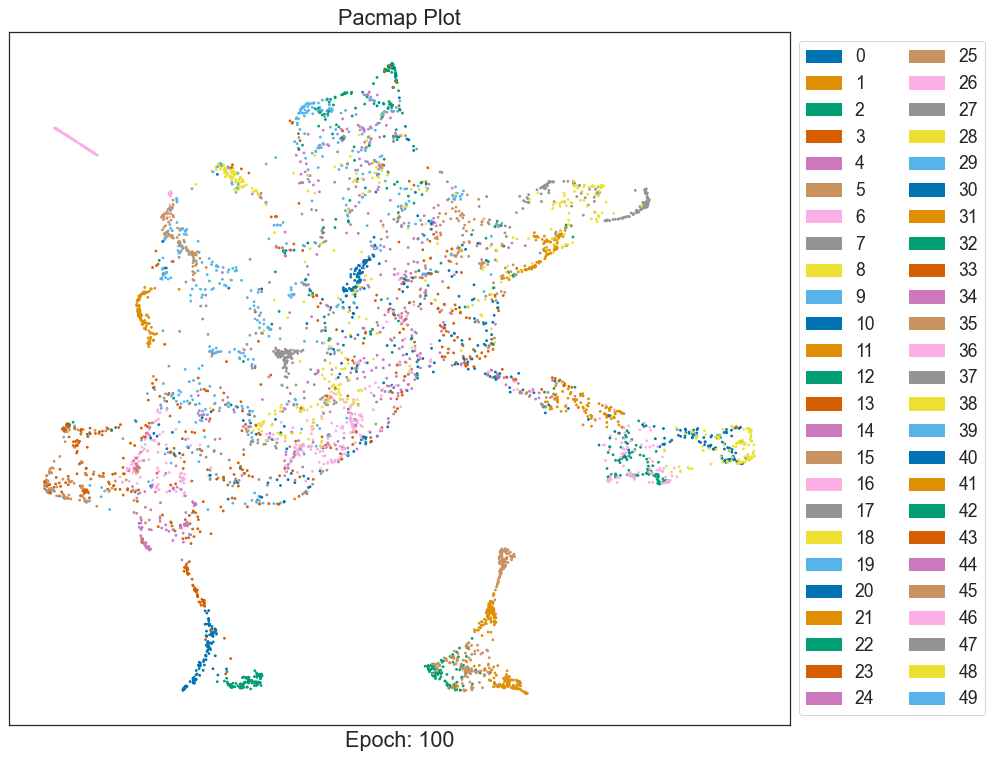

tensor(0.5378)


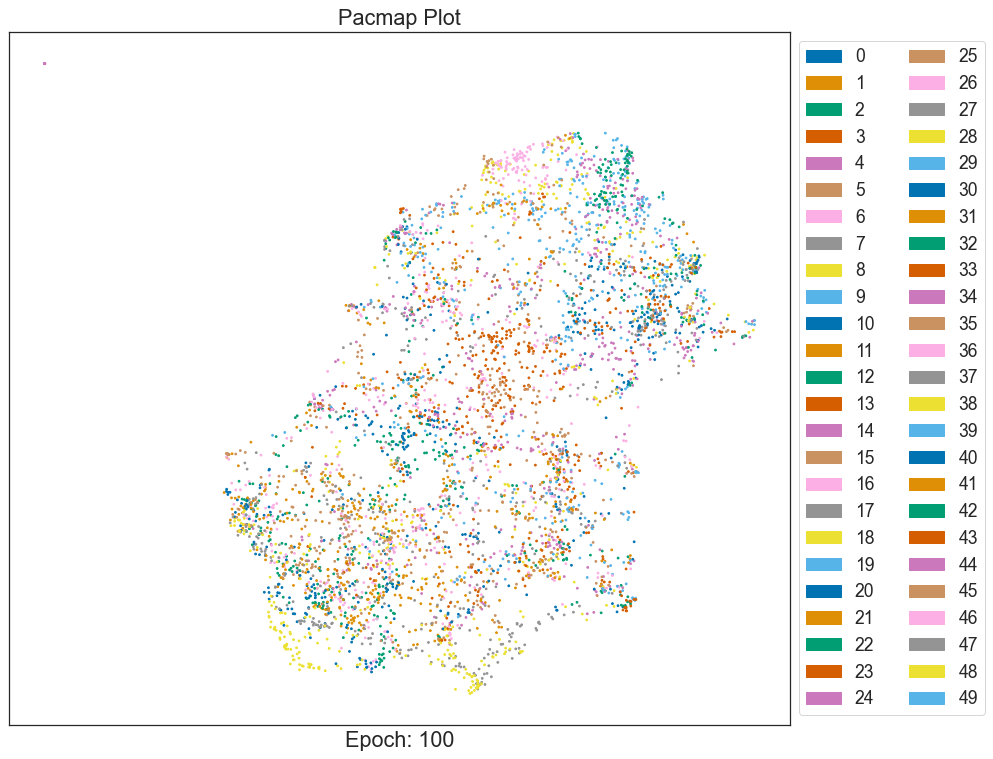

tensor(0.5024)


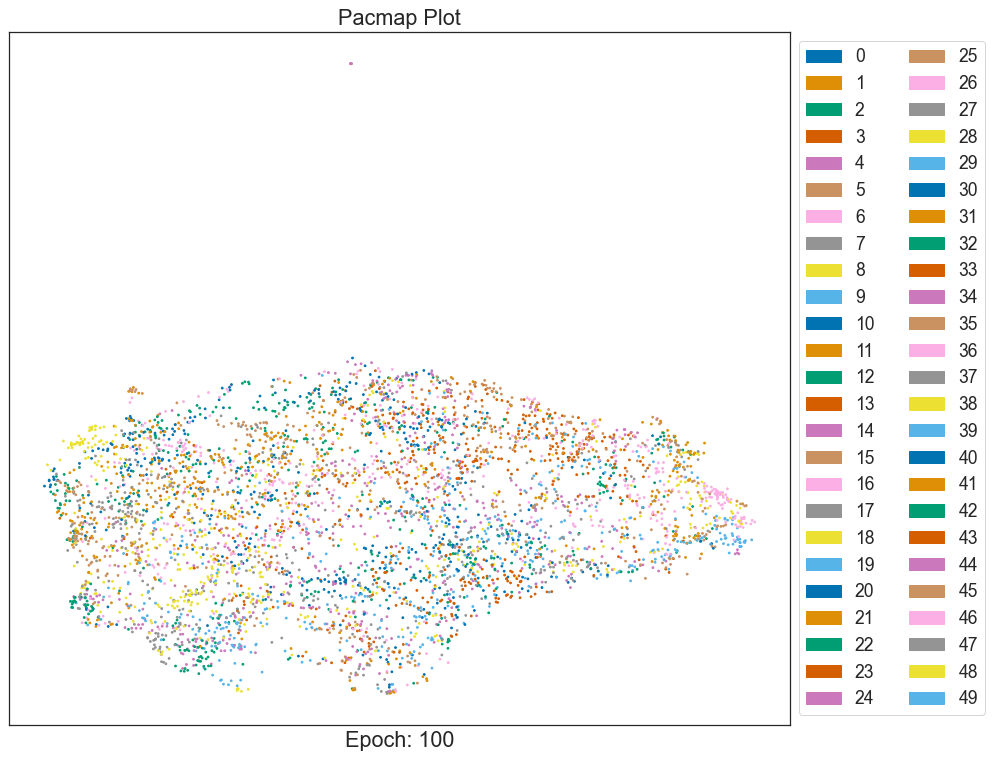

tensor(0.2088)


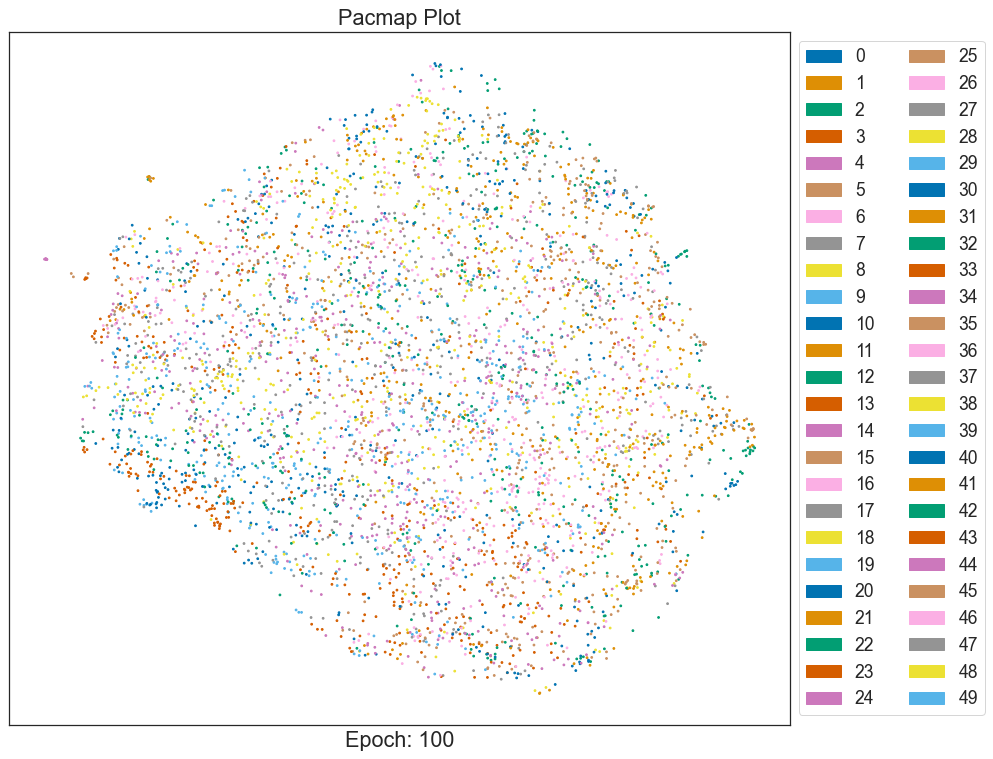

tensor(0.1048)


In [5]:
for layer in [l3, l2, l1, l0]:
# do the standard evaluation on the unsupervised representation
    features_train_eval, labels_train_eval = fuse_representations(
        layer, dataloader_train_eval, device=device)
    features_test, labels_test = fuse_representations(
        layer, dataloader_test, device=device)
    lstsq_model = lls_fit(features_train_eval,
                          labels_train_eval,
                          data_properties_dict[args.dataset].n_classes,
                          scipy=False)
    pred, test_acc = lls_eval(lstsq_model,
                              features_test,
                              labels_test)
    wb = wcss_bcss(features_test,
                   labels_test,
                   data_properties_dict[args.dataset].n_classes)
    #standard pacmap plot
    pacmap_plot = get_pacmap(
        features_test,
        labels_test,
        100,
        data_properties_dict[args.dataset].n_classes,
        data_properties_dict[args.dataset].classes)
    plt.show()
    print(test_acc)


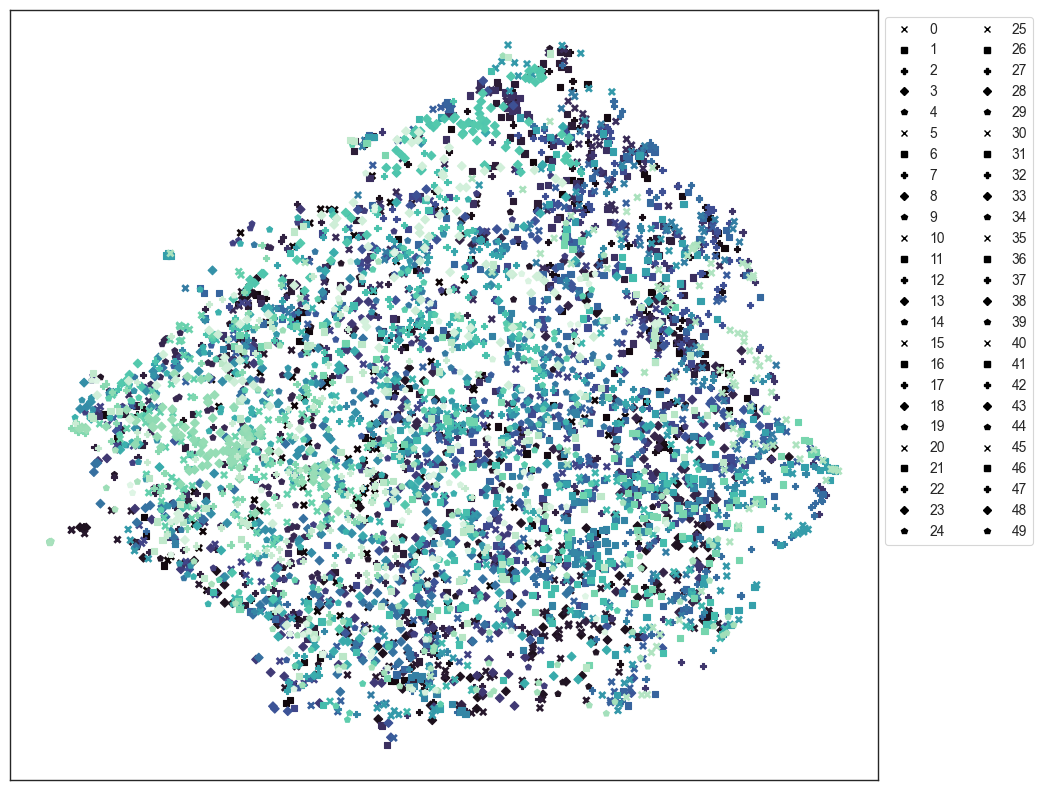

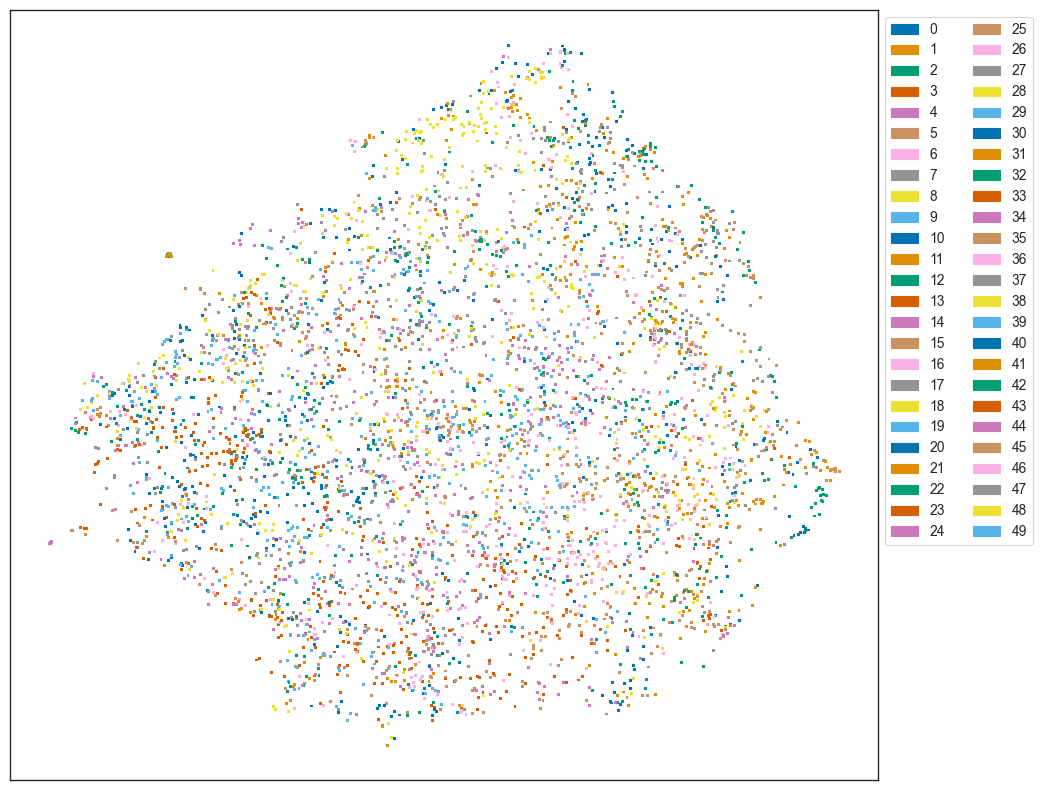

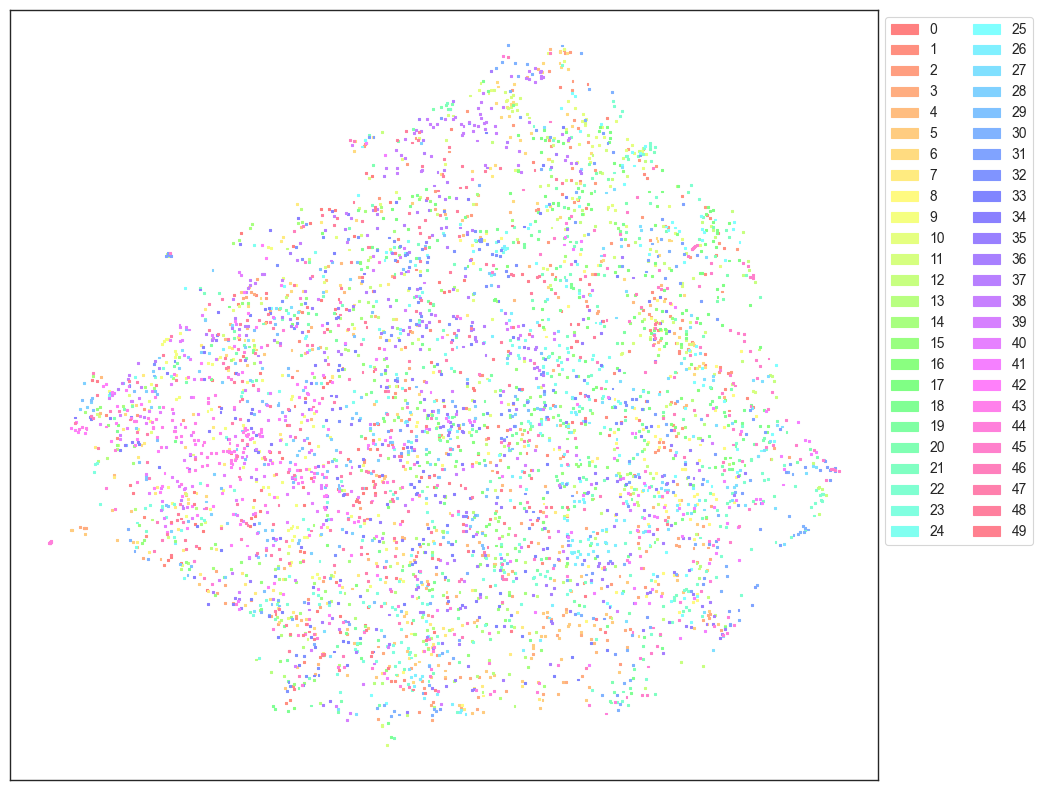

In [6]:
import pacmap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.cm import get_cmap
import matplotlib.lines as mlines

from matplotlib.colors import ListedColormap, hsv_to_rgb
import seaborn as sns


# create a custom pacmap plot
color_map = ListedColormap(sns.color_palette('colorblind', 50))
hsl_colors = [(i * (360 / 50), 50, 100) for i in range(50)]
#color_map = ListedColormap([hsv_to_rgb((hsl[0] / 360, hsl[1] / 100, hsl[2] / 100)) for hsl in hsl_colors])

#legend_patches = [Patch(color=color_map(i / n_classes), label=label) for i, label in enumerate(class_labels)]
# save the visualization result
embedding = pacmap.PaCMAP(n_components=2)
X_transformed = embedding.fit_transform(features_test.cpu().numpy(), init="pca")
fig, ax = plt.subplots(1, 1, figsize=[14,10], facecolor='w', edgecolor='k')

labels = labels_test.cpu().numpy()
time_labels = np.arange(0, len(labels), 1)
time_colormap = ListedColormap(sns.color_palette("mako", len(labels),))
# we know that in this specific version of the testset there are 100 images per class

marker_list = ["x", "s", "P", "D", "p"]*10
for i in range(50):
    # print(i*split,(i+1)*split)
    split=100
    ax.scatter(X_transformed[i*split:(i+1)*split, 0], X_transformed[i*split:(i+1)*split, 1], 
# c=,
s=20.,
marker=marker_list[i],
#facecolors='none',
c=time_colormap(time_labels)[i*split:(i+1)*split],
)

    
#ax.set_title('Pacmap Plot')
plt.xticks([]), plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

legend_patches = [mlines.Line2D([], [], color='black', marker=marker_list[i], linestyle='None',
                          markersize=4, label=i) for i in range(50)]

ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), handles=legend_patches, fontsize=10, ncol=2)
#ax.colorbar()
#legend(loc=2, prop={'size': 6})
# ax.text(-0.15, 1.05, 'C', transform=ax.transAxes, size=30, weight='medium')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=[14,10], facecolor='w', edgecolor='k')
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color_map(labels), s=2., marker='s')
#ax.set_title('Pacmap Plot')
plt.xticks([]), plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend_patches = [Patch(color=color_map(i), label=label) for i, label in enumerate(data_properties_dict[args.dataset].classes)]
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), handles=legend_patches, fontsize=10, ncol=2)

plt.show()


color_map = ListedColormap([hsv_to_rgb((hsl[0] / 360, hsl[1] / 100, hsl[2] / 100)) for hsl in hsl_colors])

fig, ax = plt.subplots(1, 1, figsize=[14,10], facecolor='w', edgecolor='k')
ax.scatter(X_transformed[:, 0], X_transformed[:, 1], c=color_map(labels), s=2., marker='s')
#ax.set_title('Pacmap Plot')
plt.xticks([]), plt.yticks([])
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
legend_patches = [Patch(color=color_map(i), label=label) for i, label in enumerate(data_properties_dict[args.dataset].classes)]
ax.legend(loc='upper left', bbox_to_anchor=(1., 1.), handles=legend_patches, fontsize=10, ncol=2)

plt.show()



In [5]:
path_to_tmp_evaluation = args.exp_dir + "/tmp/"
os.makedirs(path_to_tmp_evaluation, exist_ok=True)
# write config to a json file
save_args(path_to_tmp_evaluation, args.__dict__)

conf_mat = ConfusionMatrix(n_cls=data_properties_dict[args.dataset].n_classes)
# tensorboard writer
writer = SummaryWriter(log_dir=path_to_tmp_evaluation)

#for layer, out_dim in zip([l3, l2, l1, l0],[84,400,1176,3072]):
for layer, out_dim in zip([l0],[3072]):

    train_loss, train_acc, test_loss, test_acc, = train_linear_classifier(
    dataloader_train_eval,
    dataloader_test,
    out_dim,
    data_properties_dict[args.dataset].n_classes,
    model=layer,
    confusion_matrix=conf_mat,
    epochs=200,#args.linear_nn_epochs,
    timestep=100,#epoch + 1,
    test_every=1,#args.linear_nn_test_every,
    writer=writer,
    device=device)
    print(train_loss, train_acc, test_loss, test_acc)


[INFO:] Training linear neural network classifier at epoch 101


Loss:   0.1261: 100%|█████████████████████████| 200/200 [13:06<00:00,  3.93s/it]

0.06289596922695637 0.9856 0.12614068531376474 0.9586


In [ ]:
import matplotlib.pyplot as plt
#reload the last trained classifier (raw input)
classifier_path = path_to_tmp_evaluation + '/models/'+'classifier_epoch_100.pt'
classifier = LinearClassifier(num_features=3072)
load_model(classifier, classifier_path, device)
#model.load_state_dict(torch.load(model_path, map_location=torch.device('mps')))
classifier.eval()


# visualize weights in RGB
weights = classifier.linear_out[1].weight.to('cpu').detach().numpy().reshape(50,3,32,32)
weights -= weights.min()
weights /= weights.max()
print(weights.min(), weights.max())
weights = weights[:,:,:,:]
for i in range(50):
    plt.subplot(5, 10, i+1)
    weight = weights[i,:,:,:]
    weight = np.moveaxis(weight, 0, -1)

    plt.title(i)
    plt.imshow(weight)
    #plt.matshow(weight)
    #plt.clim(weights.min(), weights.max())  # as noted by @Eric Duminil, cmap='gray' makes the numbers stand out more
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

## 2. Try to do a linear lighting fit (n-hot)

In [ ]:
dataset_train_eval.label_by = 'color'
dataset_test.label_by = 'color'

dataloader_train_eval = DataLoader(
	dataset_train_eval, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True)
dataloader_test = DataLoader(
	dataset_test, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False)


In [ ]:
args.exp_dir = "/Users/markus/Research/Code/ColorConstancyLearning/learning/save/12-12-23_16-20__seed_0_C3_aug_time_SimCLR_reg_None"
# get the model you want to load
model_path = args.exp_dir + '/models/' + 'backbone_epoch_100.pt'
model = get_network(args, data_properties_dict).to(device)
load_model(model, model_path, device)

In [ ]:
# do the standard evaluation on the unsupervised representation
features_train_eval, labels_train_eval = fuse_representations(
    l3, dataloader_train_eval, device=device)
features_test, labels_test = fuse_representations(
    l3, dataloader_test, device=device)

#labels_train_eval = labels_train_eval.reshape([-1, 8*3])
#labels_test = labels_test.reshape([-1, 8*3])

In [ ]:
#labels_test = torch.reshape(labels_test,(-1,8,3))
lstsq_model = lls_fit(features_train_eval,
                      labels_train_eval,
                      data_properties_dict[args.dataset].n_classes,
                      label_type='n_hot',
                      scipy=False)

pred, test_acc = lls_eval(lstsq_model,
                          features_test,
                          labels_test,
                        label_type='n_hot')

#print(labels_test[15], F.sigmoid(pred[15]))
print(test_acc)

In [ ]:
# minimal example train n-hot classifier
classifier = LinearClassifier(84,24).to(device) #84 #3072
model.eval()
classifier.train()

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

epoch_loop = tqdm(range(25), ncols=80)
for epoch in epoch_loop:
    for batch, (X, y) in enumerate(dataloader_train_eval):
        #print(y)
        # needed to flatten labels and cast to float in order to make the loss function work
        X, y = X.to(device), y.to(device) #torch.flatten(y.float(), start_dim=1).to(device)
        optimizer.zero_grad()
        output = classifier(model.encoder(X))#, classifier(l0.encoder(X))
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_loop.set_description(f'Loss: {loss.item():>8.4f}')
        #print('Loss: {:.3f}'.format(loss.item()))

In [ ]:
model.eval()
classifier.eval()
test_loss, correct = 0, 0
size = len(dataloader_test.dataset)
num_batches = len(dataloader_test)

with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader_test):
        X, y = X.to(device), y.to(device) #torch.flatten(y.float(), start_dim=1).to(device)
        pred = classifier(model.encoder(X)) # classifier(l0.encoder(X))
        test_loss += criterion(pred, y).item()
        pred = torch.nn.functional.sigmoid(pred)
        y, pred = torch.reshape(y,(-1,8,3)), torch.reshape(pred,(-1,8,3))
        # first check if the prediction probability is above 50 percent
        # then check against the labels
        # then sum up over the lights (so we only match classes for all three lights)
        # check whether the sum is 3 because then we classified all color channels of one light correctly
        # then sum over lights and average over lights (8)
        #print(pred.shape, y.shape)
        correct += ((((pred>0.5) == y).sum(2) == 3).sum(1)/8).sum()
        #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(test_loss, correct.cpu().numpy())

In [ ]:
# same as wrapped into a function
training_loss, training_acc, testing_loss, testing_acc = \
train_linear_classifier(train_dataloader=dataloader_train_eval, 
                        test_dataloader=dataloader_test, 
                        input_features=84, 
                        output_features=24, 
                        model=model, 
                        loss_fn=torch.nn.BCEWithLogitsLoss(),
                        learning_rate=1e-3, 
                        epochs=25, 
                        timestep=0, 
                        test_every=10, 
                        label_type='n_hot', 
                        confusion_matrix=None, 
                        writer=None, 
                        device=device)
print(training_loss, training_acc, testing_loss, testing_acc)

## 3. Try to do a linear regression fit for intensities

In [ ]:
dataset_train_eval.label_by = 'power'
dataset_test.label_by = 'power'

dataloader_train_eval = DataLoader(
	dataset_train_eval, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True)
dataloader_test = DataLoader(
	dataset_test, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False)


In [ ]:
args.exp_dir = "/Users/markus/Research/Code/ColorConstancyLearning/learning/save/12-12-23_16-20__seed_0_C3_aug_time_SimCLR_reg_None"
# get the model you want to load
model_path = args.exp_dir + '/models/' + 'backbone_epoch_100.pt'
model = get_network(args, data_properties_dict).to(device)
load_model(model, model_path, device)

In [ ]:
# minimal example train regression model
classifier = LinearClassifier(84,8).to(device) #84 #3072
model.eval()
classifier.train()

criterion = torch.nn.L1Loss() #torch.nn.MSELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-2) #1e-3

epoch_loop = tqdm(range(25), ncols=80)
for epoch in epoch_loop:
    for batch, (X, y) in enumerate(dataloader_train_eval):
        # needed to flatten labels and cast to float in order to make the loss function work
        X, y = X.to(device), y.to(device) # y.float().to(device)
        optimizer.zero_grad()
        pred = classifier(model.encoder(X)) # classifier(l0.encoder(X))# classifier(model.encoder(X))#, classifier(l0.encoder(X))
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        epoch_loop.set_description(f'Loss: {loss.item():>8.4f}')
        #print('Loss: {:.3f}'.format(loss.item()))

In [ ]:
model.eval()
classifier.eval()
test_loss, correct = 0, 0
size = len(dataloader_test.dataset)
num_batches = len(dataloader_test)

with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader_test):
        print(y.shape)
        X, y = X.to(device), y.to(device) #.float().to(device)
        pred = classifier(model.encoder(X)) #classifier(l0.encoder(X))# classifier(model.encoder(X)) # classifier(l0.encoder(X))
        test_loss += criterion(pred, y).item()
        #print(pred[0],y[0])

test_loss /= num_batches
print(test_loss)

In [ ]:
# wrap the same thing into a function
training_loss, training_acc, testing_loss, testing_acc = \
train_linear_regressor(
    train_dataloader=dataloader_train_eval,
    test_dataloader=dataloader_test,
    input_features=84,
    output_features=8,
    model=model,
    loss_fn=torch.nn.L1Loss(),
    learning_rate=1e-2,
    epochs=25,
    timestep=0,
    test_every=10,
    writer=None,
    device=device)
print(training_loss, training_acc, testing_loss, testing_acc)

## 4. Try to do a linear regression fit for intensities + lighting

In [ ]:
dataset_train_eval.label_by = 'lighting'
dataset_test.label_by = 'lighting'

dataloader_train_eval = DataLoader(
	dataset_train_eval, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True)
dataloader_test = DataLoader(
	dataset_test, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False)


In [ ]:
args.exp_dir = "/Users/markus/Research/Code/ColorConstancyLearning/learning/save/12-12-23_16-20__seed_0_C3_aug_time_SimCLR_reg_None"
# get the model you want to load
model_path = args.exp_dir + '/models/' + 'backbone_epoch_100.pt'
model = get_network(args, data_properties_dict).to(device)
load_model(model, model_path, device)

In [ ]:
for layer, out_dim in zip([l3, l2, l1, l0],[84,400,1176,3072]):
    # wrap the same thing into a function
    training_loss, training_acc, testing_loss, testing_acc = \
    train_linear_regressor(
        train_dataloader=dataloader_train_eval,
        test_dataloader=dataloader_test,
        input_features=out_dim,
        output_features=24,
        model=layer,
        loss_fn=torch.nn.L1Loss(),
        learning_rate=1e-1,
        epochs=25,
        timestep=0,
        test_every=5,
        writer=None,
        device=device)
    print(training_loss, training_acc, testing_loss, testing_acc)

## 5. Load Tensorboard Logs to redraw learning curves